In [13]:
import keras
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 6

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from tqdm.notebook import tqdm

from scipy import stats

from sklearn import datasets

import sys 
sys.path.append("../")
from KDG import KDG

import openml

# Experiment Parameters

In [14]:
widths = [4, 3, 2]
num_trials = 100

# Data Generation

# Construct & Train Network

## Keurnal Networks

In [15]:
def construct_network(X, y, widths):
    network = keras.Sequential()
    network.add(keras.layers.Dense(widths[0], input_shape = np.shape(X)[1:], activation = 'relu'))
    for i in range(1, len(widths)):
        network.add(keras.layers.Dense(widths[i], activation = 'relu'))
    network.add(keras.layers.Dense(len(np.unique(y)), activation = 'softmax'))
    network.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(1e-3))
    network.fit(
      X, 
      keras.utils.to_categorical(y), 
      epochs = 30, 
      verbose = False,
      batch_size = int(2 ** (np.log(len(X)) / np.log(5) + 2.2))
    )

    return network

In [16]:
def train_AKN(X, y):
    X_transform, X, y_transform, y = train_test_split(X, y, test_size = 0.3)
    #X_transform, y_transform = X, y
    network = construct_network(X_transform, y_transform, widths)

    polytope_memberships = []
    last_activations = X
    
    for layer_id in range(len(network.layers)):
        weights, bias = network.layers[layer_id].get_weights()
        preactivation = np.matmul(last_activations, weights) + bias
        if layer_id == len(widths) - 1:
            binary_preactivation = (preactivation > 0.5).astype('int')
        else:
            binary_preactivation = (preactivation > 0).astype('int')
        polytope_memberships.append(binary_preactivation)
        last_activations = preactivation * binary_preactivation

    polytope_memberships = [np.tensordot(np.concatenate(polytope_memberships, axis = 1), 2 ** np.arange(0, np.shape(np.concatenate(polytope_memberships, axis = 1))[1]), axes = 1)]

    return KDG().fit(X, y, polytope_memberships)

In [17]:
def get_ece(predicted_posterior, y):
    hists = []
    hists_hat = []
    amts = []
    num_bins = 40
    eces_across_y_vals = []
    for y_val in np.unique(y):
        for i in range(num_bins):
            prop = i*1./num_bins
            inds = np.where((predicted_posterior[:, y_val] >= prop) & (predicted_posterior[:, y_val] <= prop+1./num_bins))[0]
            amts.append(len(inds))
            if len(inds) > 0:
                hists.append(len(np.where(y[inds] == y_val)[0])*1./len(inds))
                hists_hat.append(np.mean(predicted_posterior[inds, y_val]))
            else:
                hists.append(prop)
                hists_hat.append(prop + 0.5/num_bins)
        eces_across_y_vals.append(np.dot(np.abs(np.array(hists) - np.array(hists_hat)), amts) / np.sum(amts))
        return np.mean(eces_across_y_vals)

In [18]:
def get_brier(predicted_posterior, y):
    brier_across_y_vals = []
    for y_val in np.unique(y):
        brier_across_y_vals.append(np.nanmean((predicted_posterior[:, y_val] - (y == y_val).astype('int'))**2))
    return np.mean(brier_across_y_vals)

In [19]:
'''
for i in range(1, 100):
    X, y = openml.tasks.get_task(i).get_X_and_y()#datasets.load_iris(return_X_y = True)#
    X, X_test, y, y_test = train_test_split(X, y)
    print("I: {}".format(i))
    print(np.shape(X))
    print(len(np.unique(y)))
'''

'\nfor i in range(1, 100):\n    X, y = openml.tasks.get_task(i).get_X_and_y()#datasets.load_iris(return_X_y = True)#\n    X, X_test, y, y_test = train_test_split(X, y)\n    print("I: {}".format(i))\n    print(np.shape(X))\n    print(len(np.unique(y)))\n'

In [20]:
X, y = openml.tasks.get_task(6).get_X_and_y()
X, y = X[np.where(y < 2)], y[np.where(y < 2)]

DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.
DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.


In [21]:
def get_network_y_proba(X, y, n, X_test):
    random_indices = np.random.choice(len(X), int(n), replace = False)
    X, y = X[random_indices], y[random_indices]
    network = construct_network(X, y, widths)
    return network.predict_proba(X_test)
    

def get_KDE_y_proba(X, y, n, X_test):
    random_indices = np.random.choice(len(X), int(n), replace = False)
    X, y = X[random_indices], y[random_indices]
    kdg = train_AKN(X, y)
    y_proba_unnormalized = kdg.predict_proba(X_test, pooling = "class")

    y_proba = y_proba_unnormalized.copy()
    for y_val in range(np.shape(y_proba)[1]):
        y_proba[:, y_val] /= np.sum(y_proba_unnormalized, axis = 1)
        
    return y_proba

In [22]:
def get_network_y_proba(X, y, n, X_test):
    random_indices = np.random.choice(len(X), int(n), replace = False)
    X, y = X[random_indices], y[random_indices]
    network = construct_network(X, y, widths)
    return network.predict_proba(X_test)
    

    random_indices = np.random.choice(len(X), int(n), replace = False)
    X, y = X[random_indices], y[random_indices]
    kdg = train_AKN(X, y)
    y_proba_unnormalized = kdg.predict_proba(X_test, pooling = "class")

    y_proba = y_proba_unnormalized.copy()
    for y_val in range(np.shape(y_proba)[1]):
        y_proba[:, y_val] /= np.sum(y_proba_unnormalized, axis = 1)
        
    return y_proba

In [23]:
def clipped_mean(ra, low = 25, high = 75):
    ra = np.array(ra)
    lower_val = np.nanpercentile(ra, low)
    higher_val = np.nanpercentile(ra, high)
    return np.mean(ra[np.where((ra >= lower_val) & (ra <= higher_val))[0]])

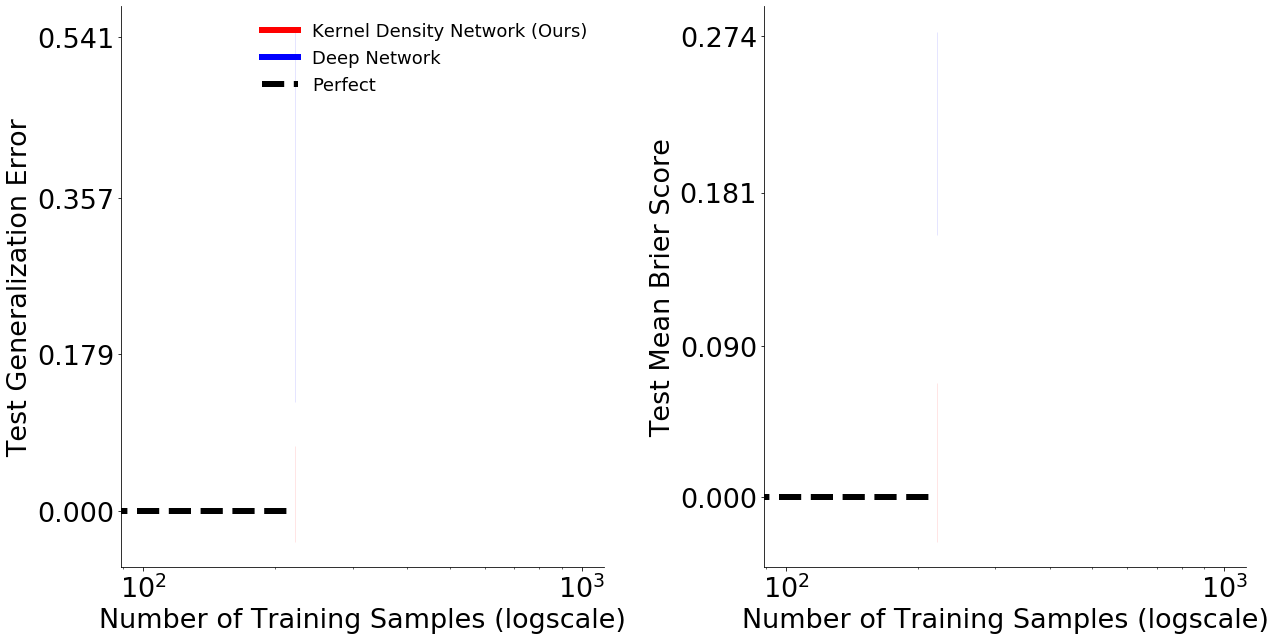

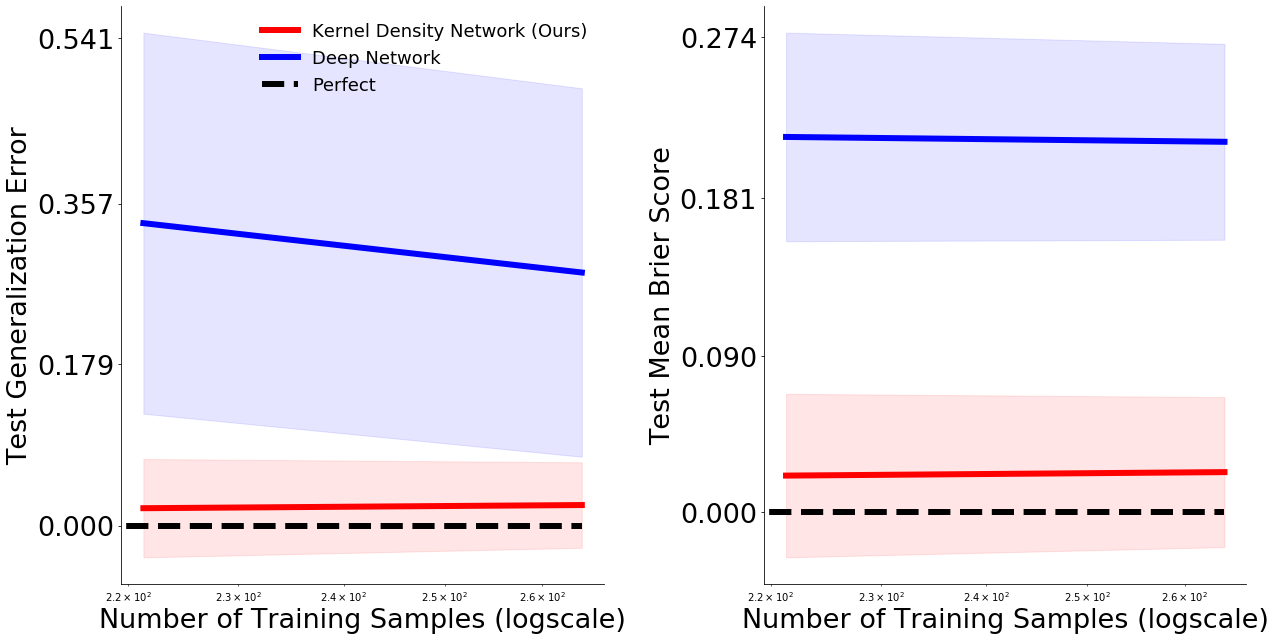

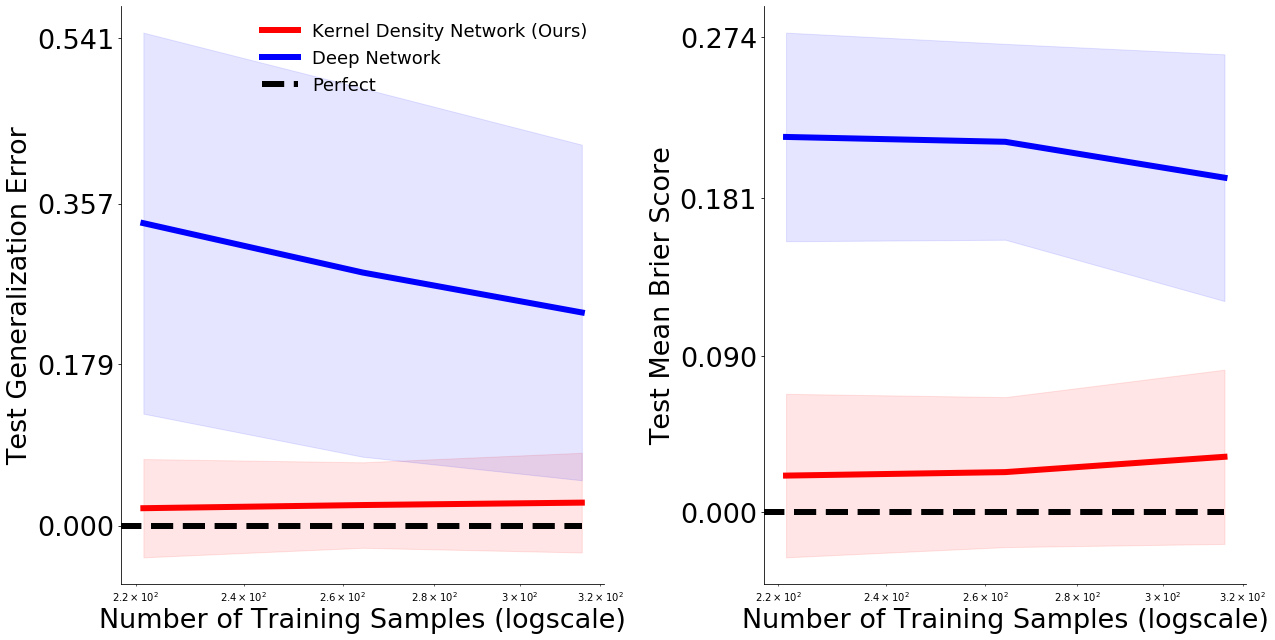

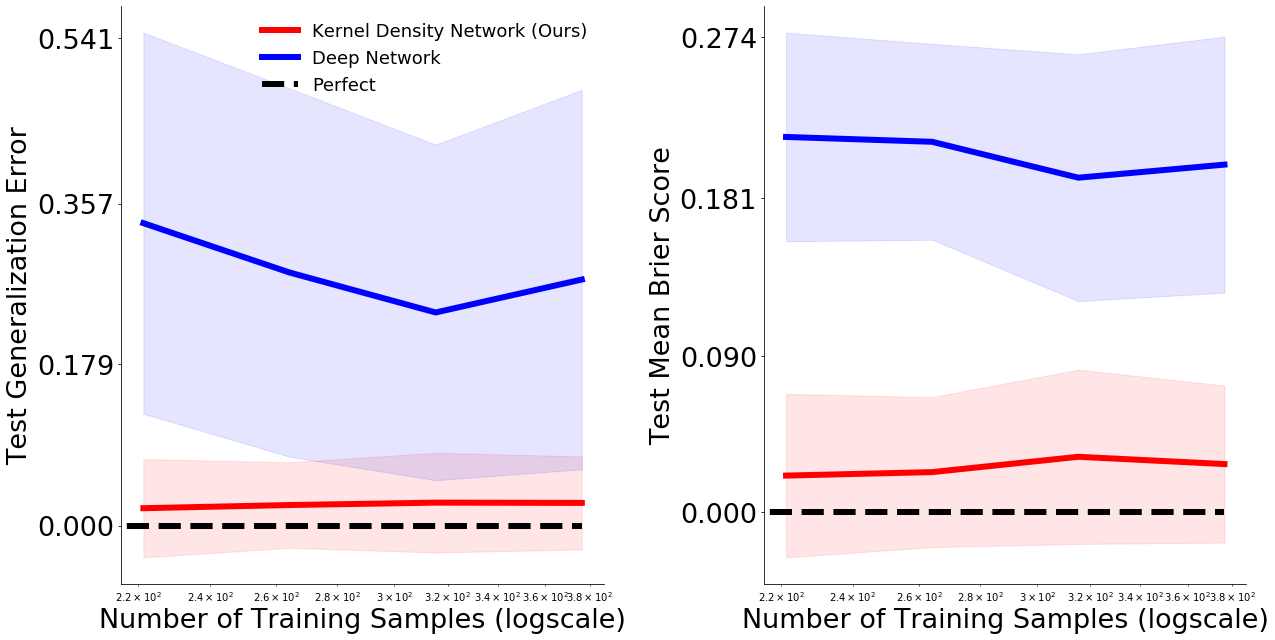

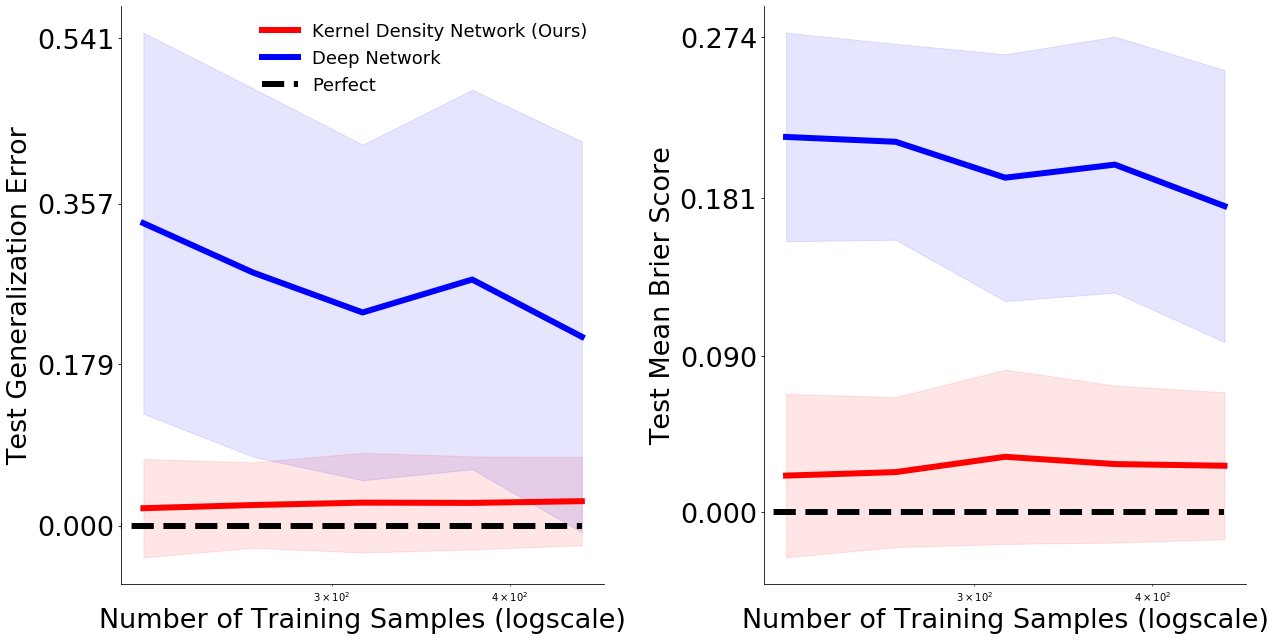

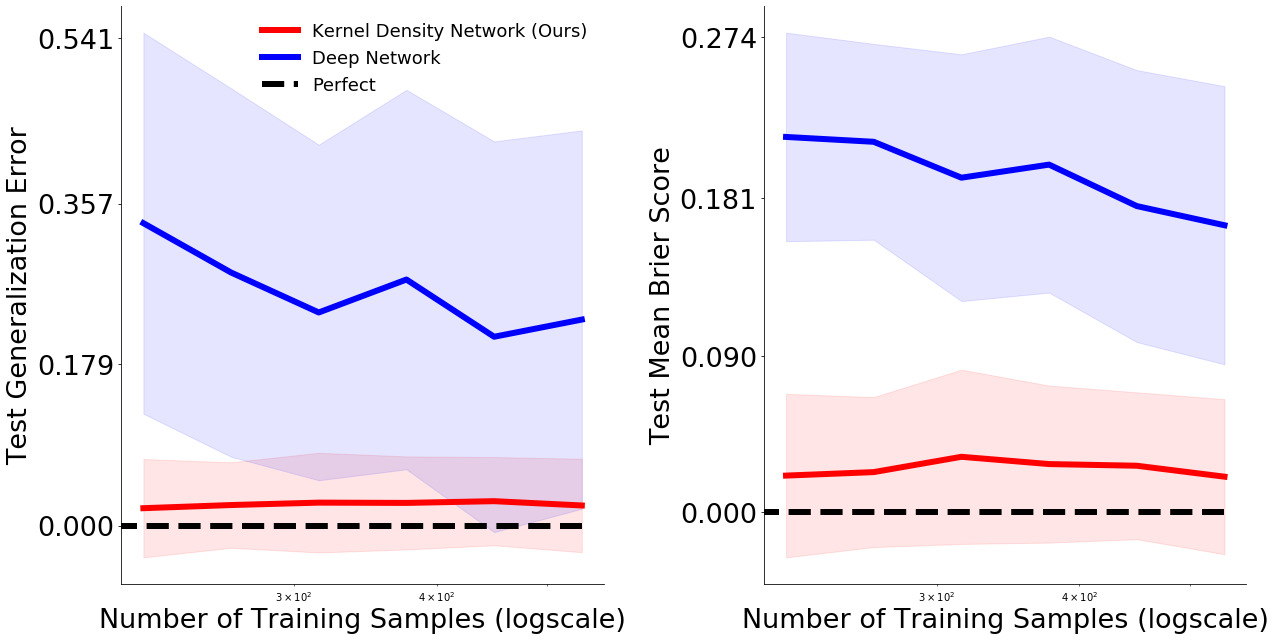

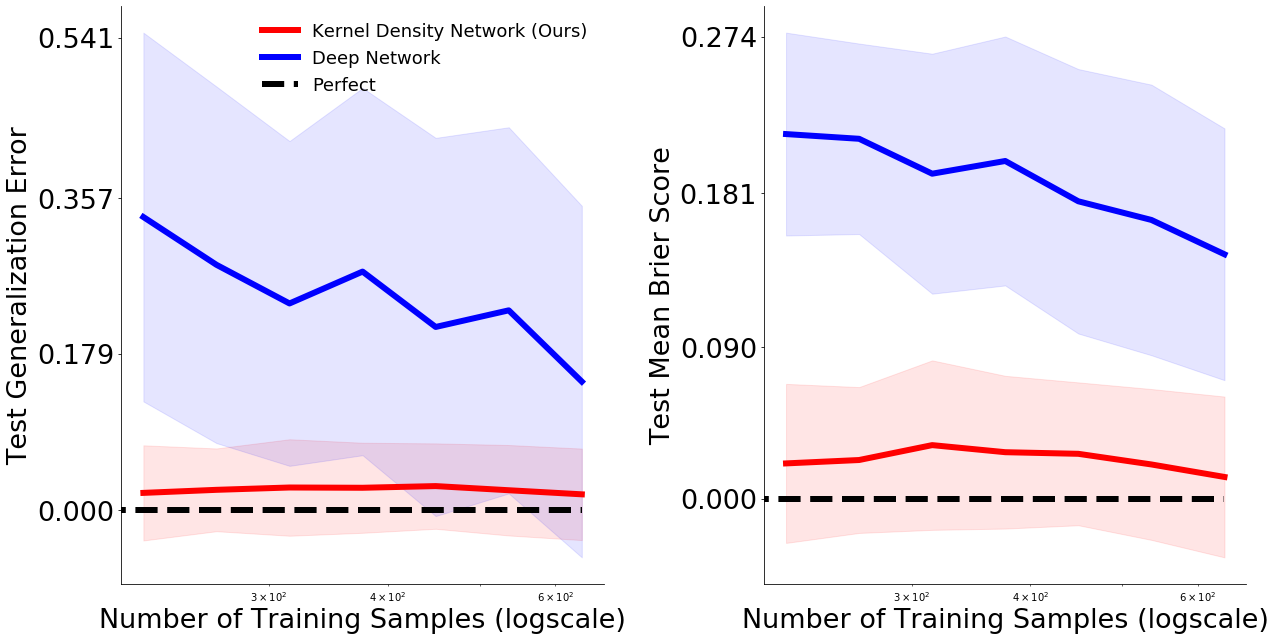

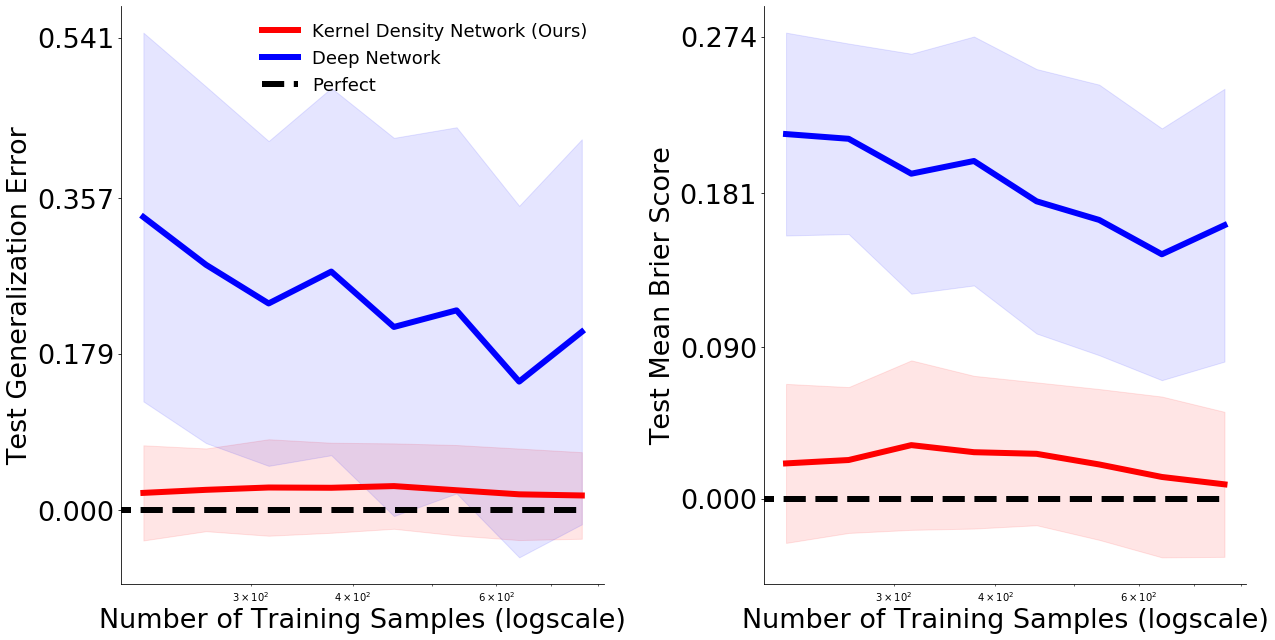

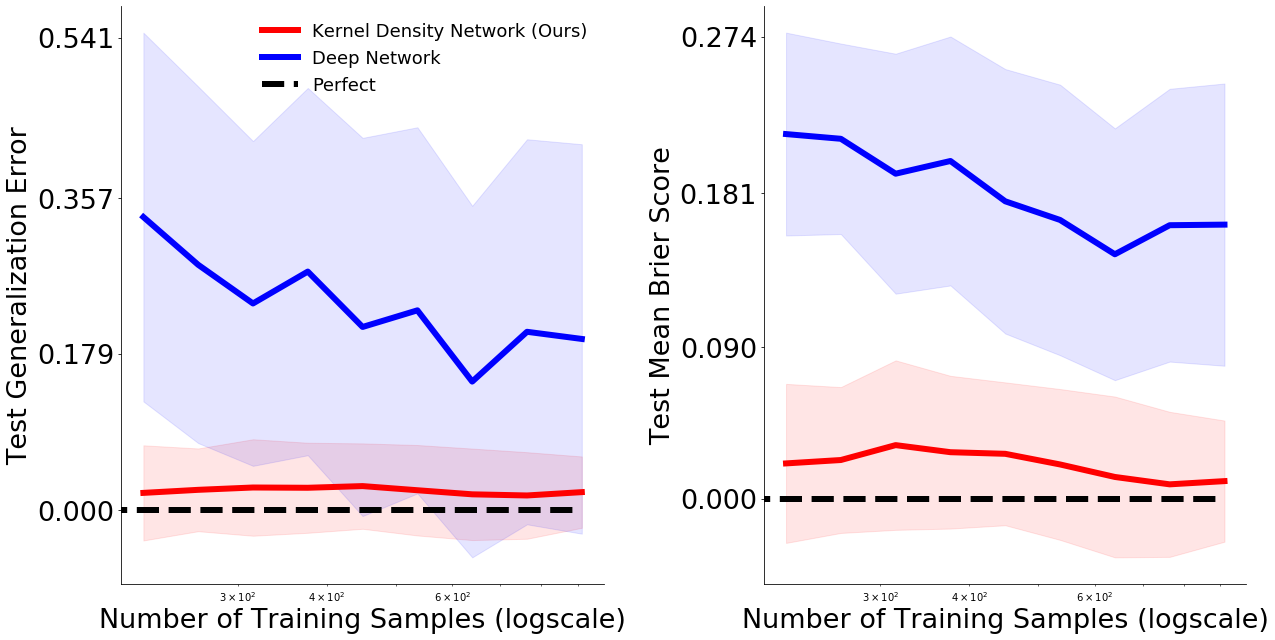

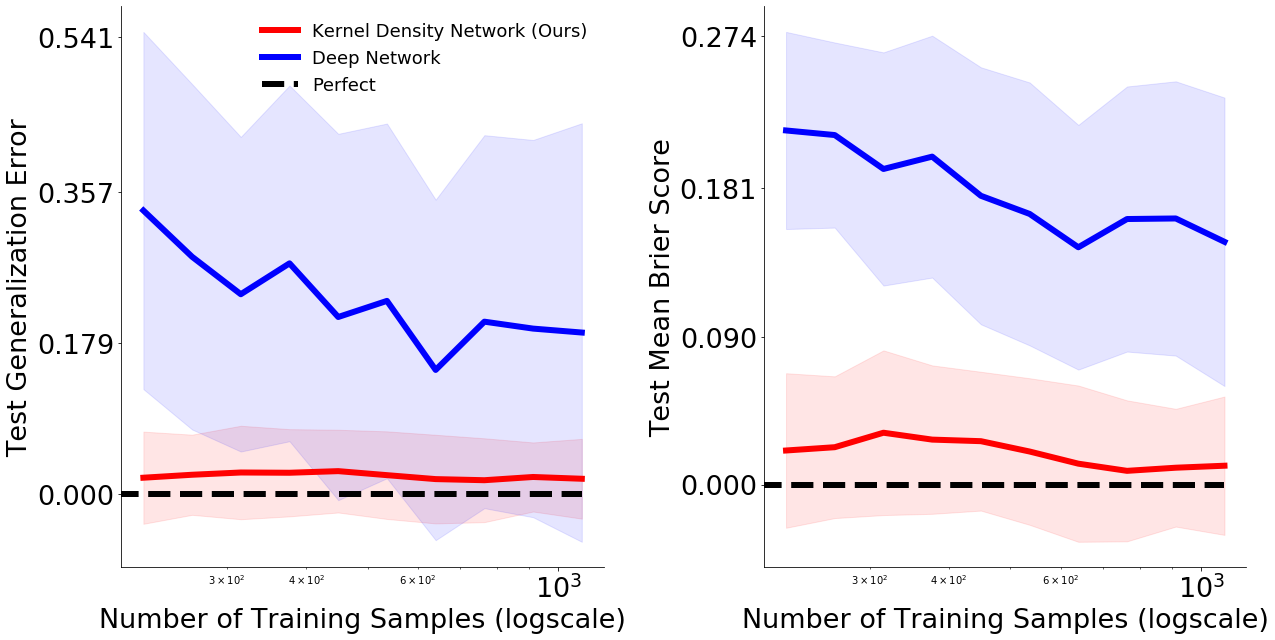

In [24]:
KDE_acc_means = []
network_acc_means = []

KDE_acc_stds = []
network_acc_stds = []

KDE_brier_means = []
network_brier_means = []

KDE_brier_stds = []
network_brier_stds = []
n_ra = np.logspace(2.5, np.log10(len(X)), num = 10, base = 10) * 0.7
ticks = np.arange(np.min(n_ra), np.max(n_ra), step = int((np.max(n_ra) - np.min(n_ra)) // 4))
ticks_ra = np.array([int(str(tick)[:1]) * 10 ** int(np.log10(tick)) for tick in ticks])
for n in tqdm(n_ra):
    KDE_accs_across_trials = []
    network_accs_across_trials = []
    KDE_briers_across_trials = []
    network_briers_across_trials = []
    for trial_idx in tqdm(range(num_trials)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 / num_trials)
        KDE_y_proba = get_KDE_y_proba(X_train, y_train, n, X_test)
        network_y_proba = get_network_y_proba(X, y, n, X_test)
        
        KDE_accs_across_trials.append(np.nanmean(np.argmax(KDE_y_proba, axis = 1) == y_test))
        network_accs_across_trials.append(np.nanmean(np.argmax(network_y_proba, axis = 1) == y_test))
        
        KDE_briers_across_trials.append(get_brier(KDE_y_proba, y_test))
        network_briers_across_trials.append(get_brier(network_y_proba, y_test))
        
    KDE_acc_means.append(clipped_mean(KDE_accs_across_trials))
    network_acc_means.append(clipped_mean(network_accs_across_trials))
    
    KDE_brier_means.append(clipped_mean(KDE_briers_across_trials))
    network_brier_means.append(clipped_mean(network_briers_across_trials))
    
    KDE_acc_stds.append(np.std(KDE_accs_across_trials))
    network_acc_stds.append(np.std(network_accs_across_trials))

    KDE_brier_stds.append(np.std(KDE_briers_across_trials))
    network_brier_stds.append(np.std(network_briers_across_trials))

    figs, ax = plt.subplots(1, 2, figsize = (18, 9))
    figs.set_facecolor("white")

    ax[0].tick_params(axis='both', which='major', labelsize=27)
    ax[0].plot(n_ra[:len(KDE_acc_means)] , 1 - np.array(KDE_acc_means), label = "Kernel Density Network (Ours)", c = "red")
    ax[0].plot(n_ra[:len(KDE_acc_means)], 1 - np.array(network_acc_means), label = "Deep Network", c = "blue")
    ax[0].hlines(0.0, 0, n_ra[len(KDE_acc_means) - 1], linestyle = "dashed", label = "Perfect", color = "black")
    ax[0].legend(fontsize = 18, loc = "upper right", frameon = False)
    ax[0].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
    ax[0].set_ylabel("Test Generalization Error", fontsize = 27)
    ax[0].set_xscale("log")
    ax[0].fill_between(n_ra[:len(KDE_acc_means)], 
                   1 - np.array(KDE_acc_means) - np.array(KDE_acc_stds),
                   1 - np.array(KDE_acc_means) + np.array(KDE_acc_stds),
                   alpha = .1,
                   color = "red")
    ax[0].fill_between(n_ra[:len(KDE_acc_means)], 
                   1 - np.array(network_acc_means) - np.array(network_acc_stds),
                   1 - np.array(network_acc_means) + np.array(network_acc_stds),
                   alpha = .1,
                   color = "blue")
    yticks_range = np.arange(0, 1 - network_acc_means[0] + network_acc_stds[0], (1 - network_acc_means[0] + network_acc_stds[0]) / 100)
    ax[0].set_yticks([round(np.percentile(yticks_range, p), 3) for p in [0, 33, 66, 100]])
    for side in {"right", "top"}:
            ax[0].spines[side].set_visible(False)

    ax[1].tick_params(axis='both', which='major', labelsize=27)
    ax[1].plot(n_ra[:len(KDE_acc_means)] , KDE_brier_means, c = "red")
    ax[1].plot(n_ra[:len(KDE_acc_means)], network_brier_means, c = "blue")
    ax[1].hlines(0.0, 0, n_ra[len(KDE_acc_means) - 1], linestyle = "dashed", color = "black")
    ax[1].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
    ax[1].set_ylabel("Test Mean Brier Score", fontsize = 27)
    ax[1].set_xscale("log")
    ax[1].fill_between(n_ra[:len(KDE_brier_means)], 
               np.array(KDE_brier_means) - np.array(KDE_brier_stds),
               np.array(KDE_brier_means) + np.array(KDE_brier_stds),
               alpha = .1,
               color = "red")
    ax[1].fill_between(n_ra[:len(KDE_brier_means)], 
                   np.array(network_brier_means) - np.array(network_brier_stds),
                   np.array(network_brier_means) + np.array(network_brier_stds),
                   alpha = .1,
                   color = "blue")
    yticks_range = np.arange(0, network_brier_means[0] + network_brier_stds[0], (network_brier_means[0] + network_brier_stds[0]) / 100)
    ax[1].set_yticks([round(np.percentile(yticks_range, p), 3) for p in [0, 33, 66, 100]])
    for side in {"right", "top"}:
            ax[1].spines[side].set_visible(False)

    figs.tight_layout()

    plt.show()

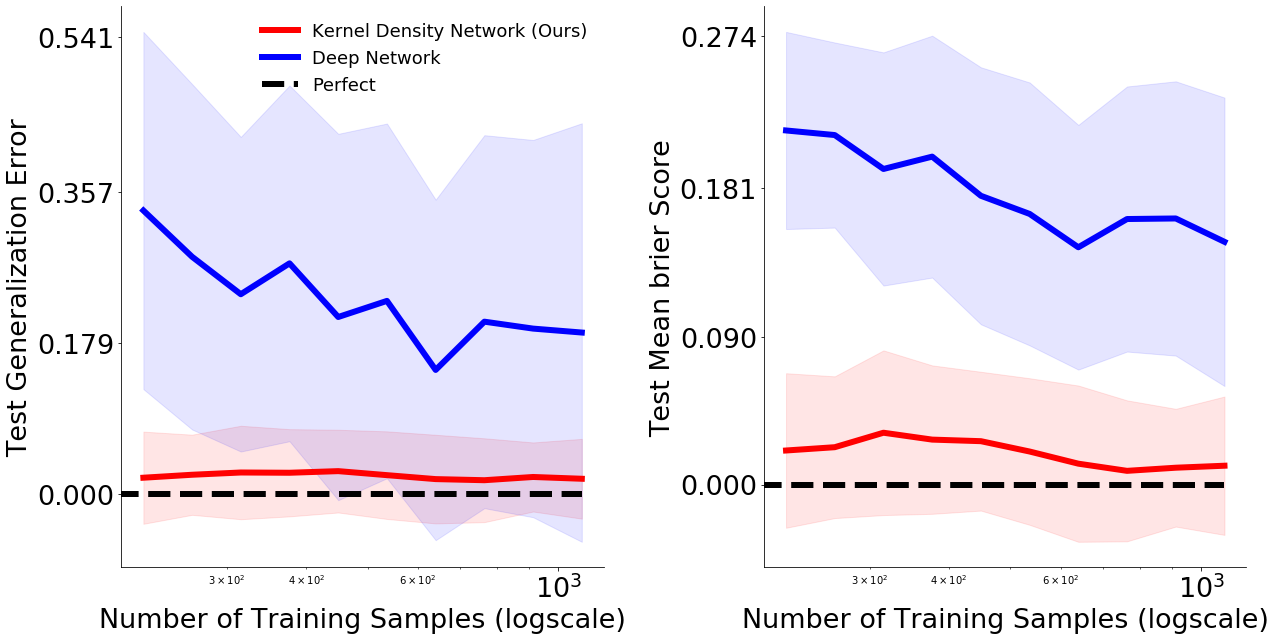

In [25]:
figs, ax = plt.subplots(1, 2, figsize = (18, 9))
figs.set_facecolor("white")

ax[0].tick_params(axis='both', which='major', labelsize=27)
ax[0].plot(n_ra , 1 - np.array(KDE_acc_means), label = "Kernel Density Network (Ours)", c = "red")
ax[0].plot(n_ra, 1 - np.array(network_acc_means), label = "Deep Network", c = "blue")
ax[0].hlines(0.0, 0, n_ra[-1], linestyle = "dashed", label = "Perfect", color = "black")
ax[0].legend(fontsize = 18, loc = "upper right", frameon = False)
ax[0].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
ax[0].set_ylabel("Test Generalization Error", fontsize = 27)
ax[0].set_xscale("log")
ax[0].fill_between(n_ra, 
                   1 - np.array(KDE_acc_means) - np.array(KDE_acc_stds),
                   1 - np.array(KDE_acc_means) + np.array(KDE_acc_stds),
                   alpha = .1,
                   color = "red")
ax[0].fill_between(n_ra, 
               1 - np.array(network_acc_means) - np.array(network_acc_stds),
               1 - np.array(network_acc_means) + np.array(network_acc_stds),
               alpha = .1,
               color = "blue")
yticks_range = np.arange(0, 1 - network_acc_means[0] + network_acc_stds[0], (1 - network_acc_means[0] + network_acc_stds[0]) / 100)
ax[0].set_yticks([round(np.percentile(yticks_range, p), 3) for p in [0, 33, 66, 100]])
for side in {"right", "top"}:
        ax[0].spines[side].set_visible(False)

ax[1].tick_params(axis='both', which='major', labelsize=27)
ax[1].plot(n_ra , KDE_brier_means, c = "red")
ax[1].plot(n_ra, network_brier_means, c = "blue")
ax[1].hlines(0.0, 0, n_ra[-1], linestyle = "dashed", color = "black")
ax[1].set_xlabel("Number of Training Samples (logscale)", fontsize = 27)
ax[1].set_ylabel("Test Mean brier Score", fontsize = 27)
ax[1].set_xscale("log")
ax[1].fill_between(n_ra, 
               np.array(KDE_brier_means) - np.array(KDE_brier_stds),
               np.array(KDE_brier_means) + np.array(KDE_brier_stds),
               alpha = .1,
               color = "red")
ax[1].fill_between(n_ra, 
               np.array(network_brier_means) - np.array(network_brier_stds),
               np.array(network_brier_means) + np.array(network_brier_stds),
               alpha = .1,
               color = "blue")
yticks_range = np.arange(0, network_brier_means[0] + network_brier_stds[0], (network_brier_means[0] + network_brier_stds[0]) / 100)
ax[1].set_yticks([round(np.percentile(yticks_range, p), 3) for p in [0, 33, 66, 100]])
for side in {"right", "top"}:
        ax[1].spines[side].set_visible(False)


figs.tight_layout()

plt.show()